In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
import transformers

from collections import Counter
from tabulate import tabulate
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# Function to pretty print DataFrame
def pprint(df):
    display(df)

In [3]:
# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Load Dataset

In [4]:
# Load the dataset
df = pd.read_excel('/content/restaurant_reviews-v2-1.xlsx')
print(df.info)

<bound method DataFrame.info of                            Restaurant  \
0                         Tikka Shack   
1                         Tikka Shack   
2                         Tikka Shack   
3                         Tikka Shack   
4    India Palace\nIndian\nRestaurant   
..                                ...   
255                       Tikka Shack   
256          Indian Palace Restaurant   
257          Indian Palace Restaurant   
258              Royal Indian Cuisine   
259              Royal Indian Cuisine   

                                                Review  Real=1/Fake=0  \
0    Great food and great atmosphere! The chicken t...              0   
1    I had heard good things about Tikka Shak so I ...              0   
2    I was driving by tikka shack one day and decid...              0   
3    Tikka Shack had the most modern and up-to-date...              0   
4    Today is the third time I've come to India Pal...              0   
..                                   

In [5]:
# consider less data for sanity testing
# df = df.iloc[:10]

# Data Preprocessing - Remove columns

In [6]:
# Display first few rows
pprint(df.head())

# Drop unnecessary columns
columns_to_drop = ['Restaurant', 'Real=1/Fake=0', 'AWL', 'ASL', 'NOW', 'NVB', 'NAJ', 'NPV', 'NST', 'CDV', 'NTP', 'TPR']
df = df.drop(columns=columns_to_drop)

# Rename sentiment column for clarity
df = df.rename(columns={'positive=1/negative=0': 'sentiment'})
print('-' * 20)
print('-' * 20)
pprint(df.head())

,Restaurant,Review,Real=1/Fake=0,positive=1/negative=0,AWL,ASL,NOW,NVB,NAJ,NPV,NST,CDV,NTP,TPR
0,Tikka Shack,Great food and great atmosphere! The chicken t...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tikka Shack,I had heard good things about Tikka Shak so I ...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tikka Shack,I was driving by tikka shack one day and decid...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tikka Shack,Tikka Shack had the most modern and up-to-date...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India Palace\nIndian\nRestaurant,Today is the third time I've come to India Pal...,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------
--------------------


,Review,sentiment
0,Great food and great atmosphere! The chicken t...,1
1,I had heard good things about Tikka Shak so I ...,0
2,I was driving by tikka shack one day and decid...,0
3,Tikka Shack had the most modern and up-to-date...,1
4,Today is the third time I've come to India Pal...,1


In [7]:
# Save df to csv
df.to_csv('preprocessed_df.csv', index=False)

# EDA

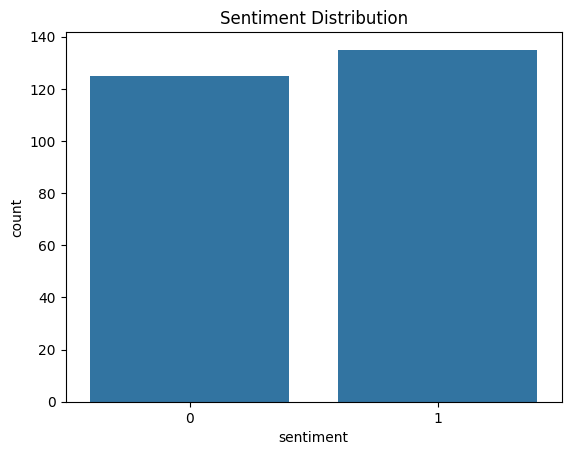

In [ ]:
# Check class distribution
sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.show()

### Word Cloud for Positive vs Negative Reviews

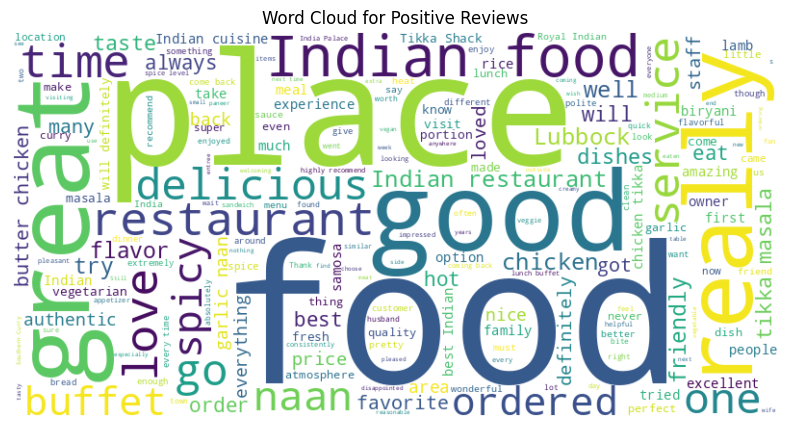

In [ ]:
from wordcloud import WordCloud

real_reviews = " ".join(df[df['sentiment'] == 1]['Review'])

wordcloud_real = WordCloud(width=800, background_color='white', height=400).generate(real_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_real, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Positive Reviews")
plt.show()

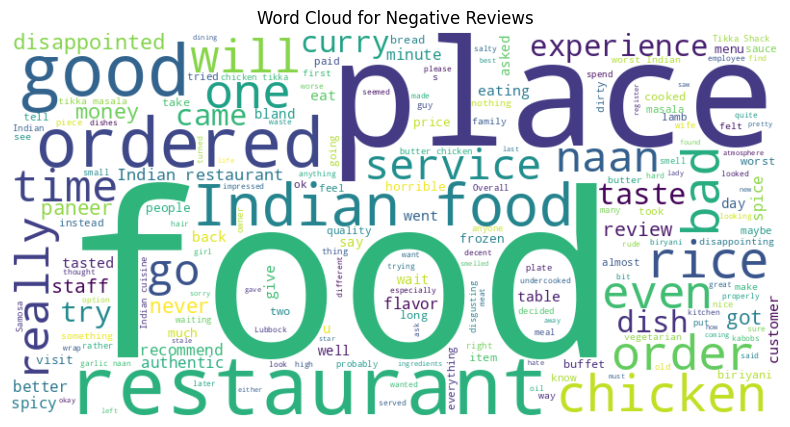

In [ ]:
fake_reviews = " ".join(df[df['sentiment'] == 0]['Review'])
wordcloud_fake = WordCloud(width=800, background_color='white', height=400).generate(fake_reviews)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_fake, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Negative Reviews")
plt.show()

# Shuffle and Train Test Split

In [ ]:
# Ensure balanced train-test split
X = df['Review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=SEED)

# Verify class distribution in train/test sets
print("Train Distribution:", Counter(y_train))
print("Test Distribution:", Counter(y_test))

Train Distribution: Counter({1: 108, 0: 100})
Test Distribution: Counter({1: 27, 0: 25})


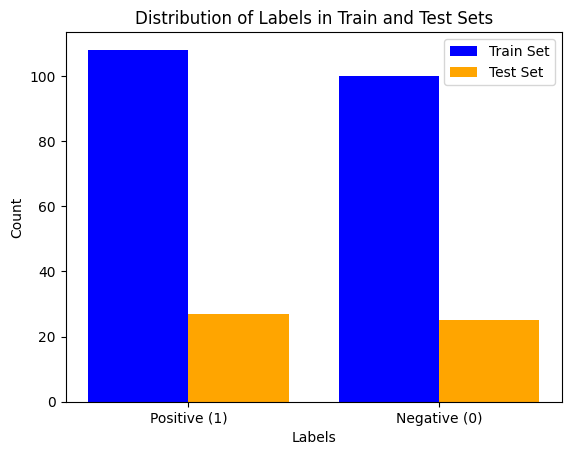

In [ ]:
# Calculate label distributions
train_label_distribution = y_train.value_counts()
test_label_distribution = y_test.value_counts()

# Plotting the distribution of labels in both training and testing sets
labels = ['Positive (1)', 'Negative (0)']
train_values = [train_label_distribution[1], train_label_distribution[0]]
test_values = [test_label_distribution[1], test_label_distribution[0]]

x = range(len(labels))

# Create the bar plot
plt.bar(x, train_values, width=0.4, label='Train Set', align='center', color='blue')
plt.bar([p + 0.4 for p in x], test_values, width=0.4, label='Test Set', align='center', color='orange')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels in Train and Test Sets')
plt.xticks([p + 0.2 for p in x], labels)
plt.legend()

# Show the plot
plt.show()

# Feature Engineering for classic models - TFIDF

In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model Training and Evaluation

## 1. TF-IDF + Logistic Regression

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_dist_lr = {
    'C': uniform(0.001, 1.0),  # Smaller C values for stronger regularization
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
}

# param_dist_lr = {
#     'C': uniform(0.1, 10),
#     'penalty': ['l1', 'l2'],
#     'solver': ['liblinear', 'saga'],
#     'max_iter': [100, 200, 500, 1000]
# }

log_reg = LogisticRegression(random_state=SEED)
random_search_lr = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_dist_lr,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=SEED,
    n_jobs=-1,
    scoring='f1',
    return_train_score=True # Add return_train_score
)

random_search_lr.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7e0ff34b3bd0>,
                                        'max_iter': [500, 1000],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Train the best Logistic Regression model found by RandomizedSearchCV
tuned_log_reg = random_search_lr.best_estimator_

# Predictions on training and test sets
y_train_pred_log_reg = tuned_log_reg.predict(X_train_tfidf)
y_test_pred_log_reg = tuned_log_reg.predict(X_test_tfidf)

# Evaluation - Train Set
accuracy_train_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
f1_train_log_reg = f1_score(y_train, y_train_pred_log_reg)

# Evaluation - Test Set
accuracy_test_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
f1_test_log_reg = f1_score(y_test, y_test_pred_log_reg)

# Print Results
print("Tuned Logistic Regression - Train Accuracy:", accuracy_train_log_reg)
print("Tuned Logistic Regression - Train F1 Score:", f1_train_log_reg)
print("Tuned Logistic Regression - Test Accuracy:", accuracy_test_log_reg)
print("Tuned Logistic Regression - Test F1 Score:", f1_test_log_reg)

Tuned Logistic Regression - Train Accuracy: 0.9903846153846154
Tuned Logistic Regression - Train F1 Score: 0.9908256880733946
Tuned Logistic Regression - Test Accuracy: 0.9423076923076923
Tuned Logistic Regression - Test F1 Score: 0.9433962264150944


## 2. TFIDF + Random Forest Classifier

In [ ]:
from scipy.stats import randint

param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 6, 7, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# param_dist_rf = {
#     'n_estimators': randint(50, 200),
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 6),
#     'min_samples_leaf': randint(1, 4),
#     'max_features': ['auto', 'sqrt']
# }

rf_clf = RandomForestClassifier(random_state=SEED)
random_search_rf = RandomizedSearchCV(
    estimator=rf_clf,
    param_distributions=param_dist_rf,
    n_iter=50,
    cv=5,
    verbose=1,
    random_state=SEED,
    n_jobs=-1,
    scoring='f1',
    return_train_score=True # Add return_train_score
)

random_search_rf.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 7, None],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [5, 10, 15],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Train the best Random Forest model found by RandomizedSearchCV
tuned_rf_clf = random_search_rf.best_estimator_

# Predictions on training and test sets
y_train_pred_rf = tuned_rf_clf.predict(X_train_tfidf)
y_test_pred_rf = tuned_rf_clf.predict(X_test_tfidf)

# Evaluation - Train Set
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
f1_train_rf = f1_score(y_train, y_train_pred_rf)

# Evaluation - Test Set
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
f1_test_rf = f1_score(y_test, y_test_pred_rf)

# Print Results
print("Tuned Random Forest - Train Accuracy:", accuracy_train_rf)
print("Tuned Random Forest - Train F1 Score:", f1_train_rf)
print("Tuned Random Forest - Test Accuracy:", accuracy_test_rf)
print("Tuned Random Forest - Test F1 Score:", f1_test_rf)

Tuned Random Forest - Train Accuracy: 0.9711538461538461
Tuned Random Forest - Train F1 Score: 0.9722222222222222
Tuned Random Forest - Test Accuracy: 0.8461538461538461
Tuned Random Forest - Test F1 Score: 0.8518518518518519


## 3. BERT pre-trained model

### BERT Tokenizer

In [ ]:
### 3️⃣ **Pre-trained BERT Model**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize input text
def tokenize_text(text_list):
    return tokenizer.batch_encode_plus(text_list, padding=True, truncation=True, max_length=256, return_tensors="pt")

train_tokens = tokenize_text(X_train.tolist())
test_tokens = tokenize_text(X_test.tolist())

# Convert to PyTorch tensors
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### Prepare dataloader for the model

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(train_tokens["input_ids"], train_tokens["attention_mask"], train_labels)
test_dataset = TensorDataset(test_tokens["input_ids"], test_tokens["attention_mask"], test_labels)

train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=8)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=8)

### Load BERT model

In [ ]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Fine-Tune BERT model

In [ ]:
# Fine-tune BERT
model.train()
for epoch in range(3):
    print(f"Epoch {epoch+1} started")
    for batch_idx, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        model.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        # Print loss every 10 batches
        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

print("Fine-Tuning complete")

Epoch 1 started
Batch 0, Loss: 0.8338069319725037
Batch 10, Loss: 0.5916637182235718
Batch 20, Loss: 0.6087679266929626
Epoch 2 started
Batch 0, Loss: 0.5875067114830017
Batch 10, Loss: 0.39020752906799316
Batch 20, Loss: 0.22130316495895386
Epoch 3 started
Batch 0, Loss: 0.19559571146965027
Batch 10, Loss: 0.04504945129156113
Batch 20, Loss: 0.04294903948903084
Fine-Tuning complete


### Evaluate BERT model

In [ ]:
# Evaluate on both Train and Test sets
def evaluate_bert(model, dataloader, device):
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds)

    return accuracy, f1,preds,true_labels

# Compute Train and Test Scores
accuracy_train_bert, f1_train_bert,y_train_pred_bert, y_train_true_bert  = evaluate_bert(model, train_dataloader, device)
accuracy_test_bert, f1_test_bert ,y_test_pred_bert, y_test_true_bert = evaluate_bert(model, test_dataloader, device)


# Print Results
print("BERT - Train Accuracy:", accuracy_train_bert)
print("BERT - Train F1 Score:", f1_train_bert)
print("BERT - Test Accuracy:", accuracy_test_bert)
print("BERT - Test F1 Score:", f1_test_bert)

BERT - Train Accuracy: 0.9951923076923077
BERT - Train F1 Score: 0.9953488372093023
BERT - Test Accuracy: 0.9615384615384616
BERT - Test F1 Score: 0.9615384615384616


# Evaluation Metrics

In [ ]:
# Create a DataFrame to store the results for train and test accuracies and F1 scores
train_accuracy = [accuracy_train_log_reg, accuracy_train_rf, accuracy_train_bert]
test_accuracy = [accuracy_test_log_reg, accuracy_test_rf, accuracy_test_bert]
train_f1 = [f1_train_log_reg, f1_train_rf, f1_train_bert]
test_f1 = [f1_test_log_reg, f1_test_rf, f1_test_bert]

results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "BERT"],
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy,
    "Train F1 Score": train_f1,
    "Test F1 Score": test_f1
})

pprint(results_df)  # Display the results

,Model,Train Accuracy,Test Accuracy,Train F1 Score,Test F1 Score
0,Logistic Regression,0.990385,0.942308,0.990826,0.943396
1,Random Forest,0.971154,0.846154,0.972222,0.851852
2,BERT,0.995192,0.961538,0.995349,0.961538


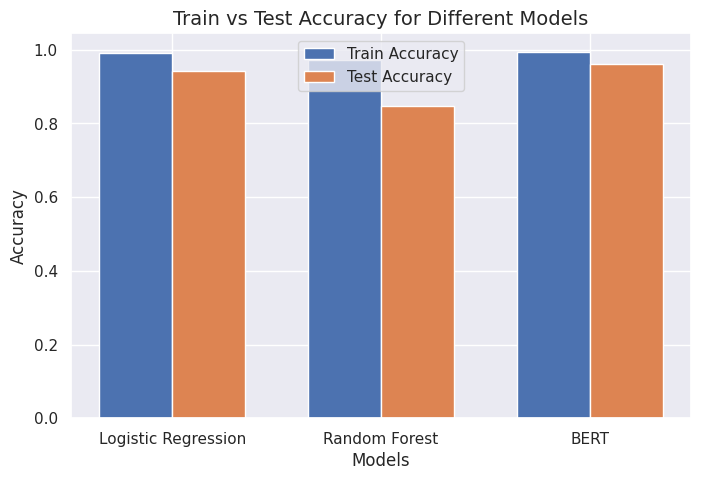

In [ ]:
models = ["Logistic Regression", "Random Forest", "BERT"]
# Create DataFrame
results_df = pd.DataFrame({
    "Model": models,
    "Train Accuracy": train_accuracy,
    "Test Accuracy": test_accuracy
})

# Set dark theme for better visibility
sns.set_theme(style="darkgrid")

# Plot bar chart
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35
index = range(len(models))

# Dark color choices
train_color = "#4c72b0"  # Dark blue
test_color = "#dd8452"   # Dark orange

# Plot bars
ax.bar(index, train_accuracy, bar_width, label="Train Accuracy", color=train_color)
ax.bar([i + bar_width for i in index], test_accuracy, bar_width, label="Test Accuracy", color=test_color)

# Labels and Title
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Train vs Test Accuracy for Different Models", fontsize=14)
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

# Show plot
plt.show()

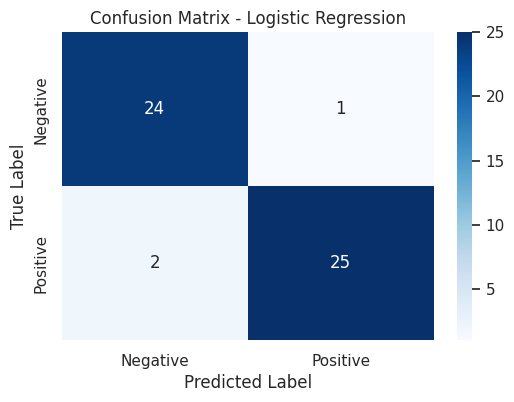

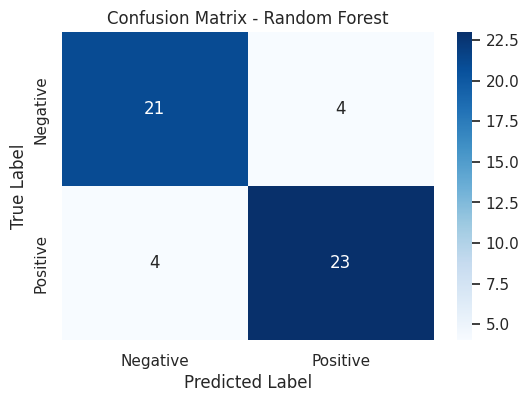

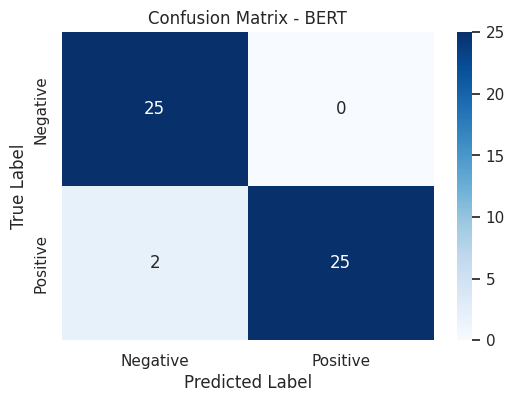

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(y_test, y_test_pred_log_reg, "Logistic Regression")
plot_confusion_matrix(y_test, y_test_pred_rf, "Random Forest")
# Now, plot confusion matrix
plot_confusion_matrix(y_test_true_bert, y_test_pred_bert, "BERT")
